<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/Model_Trainings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch-geometric networkx
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.8 MB/s eta 0:00:00


In [2]:
import os
disorder_folder_path = '/content/drive/My Drive/Disorder'


In [10]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
import torch.nn.functional as F
import pickle
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv, global_mean_pool
from google.colab import drive
import matplotlib.cm as cm
import shap
import os
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
graphs = '/content/drive/My Drive/Disorder/graphs_processed.pkl'
#graphs ="/content/graphs.pkl"
with open(graphs, 'rb') as f:
    graphs = pickle.load(f)


In [5]:
graphs[0].x

tensor([[ 2.8000e+01,  1.0000e+00,  2.8000e+01,  0.0000e+00,  0.0000e+00,
          2.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  5.0000e+00,  4.0000e+00,  1.0000e+00,  9.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          2.0000e+00,  0.0000e+00,  2.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  8.0000e+00,
          1.0000e+00,  4.0000e+00,  1.

In [34]:
# data = graphs[0]
# print("Node Features (x):")
# print(data.x)  # The feature matrix of nodes

# print("\nEdge Index (edge_index):")
# print(data.edge_index)  # The edges between nodes, where edge_index[0] is the source and edge_index[1] is the target

# print("\nGraph Label (y):")
# print(data.y)  # The label or target for the entire graph (for regression or classification)

# print("\nNumber of Nodes:", data.x.size(0))  # The number of nodes (rows in the feature matrix)
# print("Number of Node Features:", data.x.size(1))  # The number of features per node (columns in the feature matrix)
# print("Number of Edges:", data.edge_index.size(1))  # The number of edges (columns in edge_index)

## Linear Regression

In [40]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        # Linear layer to map input to output
        self.linear = nn.Linear(input_dim, 1)  # Output size is 1 for regression

    def forward(self, data):
        x, batch = data.x, data.batch
        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)
        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)
        # Apply the mask to valid entries
        x = x * mask.float()  # Mask invalid features
        # Aggregate node features to graph-level
        x = global_mean_pool(x, batch)
        # Pass through the linear layer
        out = self.linear(x)
        return out.view(-1)  # Output shape: (batch_size,)

## CLasic MLP Method

In [6]:
class MLPWithAggregatedFeaturesMasked(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPWithAggregatedFeaturesMasked, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, batch = data.x, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Mean pooling over node features (using valid entries only)
        x = global_mean_pool(x * mask.float(), batch)  # Pooling over the nodes in the same graph

        # MLP Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x.view(-1)


## Transformer Architecture

In [7]:
class TransformerEncoderMasked(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, nhead=4):
        super(TransformerEncoderMasked, self).__init__()

        # Adjust nhead to be compatible with input_dim
        while input_dim % nhead != 0:
            nhead -= 1
            if nhead <= 1:
                nhead = 1
                break
        print(f"Adjusted number of heads: {nhead}")

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, batch = data.x, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply Transformer layers
        x = self.transformer(x)

        # Pooling over the nodes in the same graph (using valid entries only)
        x = global_mean_pool(x * mask.float(), batch)

        # Final MLP layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.view(-1)


## Graph Neural Network

## Graph Attention Nerwork



In [38]:
class GNNWithMasking(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim):
        super(GNNWithMasking, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)  # Add Dropout
        self.fc = nn.Linear(out_dim, 1)  # Output a single value (for regression)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GNN layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.bn2(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling over the nodes in the same graph
        x = self.dropout(x)

        # Pass through final fully connected layer to output a single value
        x = self.fc(x)
        return x.view(-1)  # Ensure output shape is correct (batch size)



## Graph Attention Network

In [39]:
# Define GNN model with masking, batch normalization, dropout, and GAT
class GATWithMasking(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim, num_heads=4):
        super(GATWithMasking, self).__init__()

        # GATConv layers
        self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Output one attention head for the final layer

        # BatchNorm and Dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)  # Add Dropout

        # Fully connected layer for regression output
        self.fc = nn.Linear(out_dim, 1)  # Output a single value (for regression)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GATConv layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.bn2(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling over the nodes in the same graph
        x = self.dropout(x)

        # Pass through final fully connected layer to output a single value
        x = self.fc(x)
        return x.view(-1)  # Ensure output shape is correct (batch size)


## Cross Validation

In [41]:
# Custom weighted MSE loss function
class WeightedMSELoss(nn.Module):
    def __init__(self, repressor_weight=5.0, default_weight=1.0):
        super(WeightedMSELoss, self).__init__()
        self.repressor_weight = repressor_weight
        self.default_weight = default_weight

    def forward(self, predictions, targets):
        # Create weight mask: Higher weight for repressors (targets < -1)
        weights = torch.where(targets < -1, self.repressor_weight, self.default_weight)

        # Compute weighted MSE loss
        loss = weights * (predictions - targets) ** 2
        return loss.mean()


from sklearn.model_selection import StratifiedKFold
import numpy as np

def get_stratified_labels(graphs):
    """Create labels for stratified splitting based on target values."""
    labels = []
    for graph in graphs:
        if graph.y.item() < -1:
            labels.append(0)  # Repressor
        elif graph.y.item() > 1:
            labels.append(1)  # Activator
        else:
            labels.append(2)  # Other
    return np.array(labels)

def cross_validate_stratified(graphs, model_name, model_type, k_folds=5, num_epochs=50, hidden_dim=64, out_dim=32):
    # Get stratified labels for splitting
    labels = get_stratified_labels(graphs)

    # Use StratifiedKFold to ensure balanced splits
    stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)

    fold_results = []
    train_loss_history = []
    test_loss_history = []
    best_model = None
    best_test_loss = float('inf')
    best_test_loader = None

    all_true_values = []  # To store true values
    all_predicted_values = []  # To store predicted values

    model_folder = f'/content/drive/My Drive/Disorder/Models/{model_name}'
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    # Initialize the weighted loss function
    criterion = WeightedMSELoss(repressor_weight=5.0)  # Adjust weight as needed

    for fold, (train_idx, test_idx) in enumerate(stratified_kfold.split(graphs, labels)):
        print(f'Fold {fold + 1}/{k_folds}')

        train_dataset = [graphs[i] for i in train_idx]
        test_dataset = [graphs[i] for i in test_idx]

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        num_features = graphs[0].x.shape[1]  # Assume all graphs have the same feature dimension

        # Select the model based on model_type
        if model_type == 'MLP':
          model = MLPWithAggregatedFeaturesMasked(num_features, hidden_dim, 1)
        elif model_type == 'Transformer':
          model = TransformerEncoderMasked(num_features, hidden_dim)
        elif model_type == 'GNN':
          model = GNNWithMasking(num_features, hidden_dim, out_dim)
        elif model_type == 'GAT':
          model = GATWithMasking(num_features, hidden_dim, out_dim)
        elif model_type == "Linear":
          model = LinearRegressionModel(num_features)
        else:
            raise ValueError("Invalid model type")

        optimizer = optim.Adam(model.parameters(), lr=0.01)

        fold_train_losses = []
        fold_test_losses = []

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            total_train_loss = 0

            for data in train_loader:
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)  # Use weighted MSE loss
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)

            # Evaluation phase
            model.eval()
            total_test_loss = 0
            epoch_true_values = []  # To store true values for this epoch
            epoch_predicted_values = []  # To store predicted values for this epoch

            with torch.no_grad():
                for data in test_loader:
                    out = model(data)

                    # Store true and predicted values
                    epoch_true_values.extend(data.y.cpu().numpy())
                    epoch_predicted_values.extend(out.cpu().numpy())

                    loss = criterion(out, data.y)  # Use weighted MSE loss
                    total_test_loss += loss.item()

            avg_test_loss = total_test_loss / len(test_loader)
            fold_test_losses.append(avg_test_loss)

            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

        # Save the predictions and true values for each fold
        all_true_values.append(epoch_true_values)
        all_predicted_values.append(epoch_predicted_values)

        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model = model.state_dict()
            best_test_loader = test_loader

        train_loss_history.append(fold_train_losses)
        test_loss_history.append(fold_test_losses)

        fold_results.append(avg_test_loss)

    model_path = os.path.join(model_folder, 'best_model.pth')
    torch.save(best_model, model_path)
    print(f'Saved best model with test loss: {best_test_loss}')

    avg_test_loss = sum(fold_results) / k_folds
    print(f'Average Test Loss across all folds: {avg_test_loss}')

    log_path = os.path.join(model_folder, 'loss_log.txt')
    with open(log_path, 'w') as f:
        f.write(f'Best Test Loss: {best_test_loss}\n')
        f.write(f'Average Test Loss: {avg_test_loss}\n')
        for fold in range(k_folds):
            f.write(f'Fold {fold + 1} Train Losses: {train_loss_history[fold]}\n')
            f.write(f'Fold {fold + 1} Test Losses: {test_loss_history[fold]}\n')

    # Return true and predicted values for further analysis
    return train_loss_history, test_loss_history, best_test_loader, model_folder, all_true_values, all_predicted_values

def cross_validate(graphs, model_name, model_type, k_folds=5, num_epochs=50, hidden_dim=64, out_dim=32):
    kfold = KFold(n_splits=k_folds, shuffle=True)

    fold_results = []
    train_loss_history = []
    test_loss_history = []
    best_model = None
    best_test_loss = float('inf')
    best_test_loader = None

    all_true_values = []  # To store true values
    all_predicted_values = []  # To store predicted values

    model_folder = f'/content/drive/My Drive/Disorder/Models/{model_name}'
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    criterion = WeightedMSELoss(repressor_weight=5.0)

    for fold, (train_idx, test_idx) in enumerate(kfold.split(graphs)):
        print(f'Fold {fold + 1}/{k_folds}')

        train_dataset = [graphs[i] for i in train_idx]
        test_dataset = [graphs[i] for i in test_idx]

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        num_features = graphs[0].x.shape[1]  # Assume all graphs have the same feature dimension

        # Select the model based on model_type
        if model_type == 'MLP':
            model = MLPWithAggregatedFeaturesMasked(num_features, hidden_dim, 1)
        elif model_type == 'Transformer':
            model = TransformerEncoderMasked(num_features, hidden_dim)
        elif model_type == 'GNN':
            model = GNNWithMasking(num_features, hidden_dim, out_dim)
        elif model_type == 'GAT':
            model = GATWithMasking(num_features, hidden_dim, out_dim)
        else:
            raise ValueError("Invalid model type")

        optimizer = optim.Adam(model.parameters(), lr=0.01)
        #criterion = nn.MSELoss()  # Regression

        fold_train_losses = []
        fold_test_losses = []

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            total_train_loss = 0
            for data in train_loader:
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)

            # Evaluation phase
            model.eval()
            total_test_loss = 0
            epoch_true_values = []  # To store true values for this epoch
            epoch_predicted_values = []  # To store predicted values for this epoch

            with torch.no_grad():
                for data in test_loader:
                    out = model(data)

                    # Store true and predicted values
                    epoch_true_values.extend(data.y.cpu().numpy())
                    epoch_predicted_values.extend(out.cpu().numpy())

                    loss = criterion(out, data.y)
                    total_test_loss += loss.item()

            avg_test_loss = total_test_loss / len(test_loader)
            fold_test_losses.append(avg_test_loss)

            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

        # Save the predictions and true values for each fold
        all_true_values.append(epoch_true_values)
        all_predicted_values.append(epoch_predicted_values)

        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model = model.state_dict()
            best_test_loader = test_loader

        train_loss_history.append(fold_train_losses)
        test_loss_history.append(fold_test_losses)

        fold_results.append(avg_test_loss)

    model_path = os.path.join(model_folder, 'best_model.pth')
    torch.save(best_model, model_path)
    print(f'Saved best model with test loss: {best_test_loss}')

    avg_test_loss = sum(fold_results) / k_folds
    print(f'Average Test Loss across all folds: {avg_test_loss}')

    log_path = os.path.join(model_folder, 'loss_log.txt')
    with open(log_path, 'w') as f:
        f.write(f'Best Test Loss: {best_test_loss}\n')
        f.write(f'Average Test Loss: {avg_test_loss}\n')
        for fold in range(k_folds):
            f.write(f'Fold {fold + 1} Train Losses: {train_loss_history[fold]}\n')
            f.write(f'Fold {fold + 1} Test Losses: {test_loss_history[fold]}\n')

    # Return true and predicted values for further analysis
    return train_loss_history, test_loss_history, best_test_loader, model_folder, all_true_values, all_predicted_values


## Benchmarking Each Model

In [57]:
models_to_try = ['Linear', 'MLP', 'Transformer', 'GNN', 'GAT']
for model_type in models_to_try:
    print(f'Running cross-validation for {model_type}')
    weights_name = f'{model_type}_trial'
    train_losses, test_losses, test_loader, model_folder, all_true_values, all_predicted_values = cross_validate(
        graphs, weights_name, model_type=model_type, k_folds=5, num_epochs=50, hidden_dim=64, out_dim=32
    )
      # Flatten the true and predicted values (since they are collected over multiple epochs/folds)
  # all_true_values = [item for sublist in all_true_values for item in sublist]
  # all_predicted_values = [item for sublist in all_predicted_values for item in sublist]

  # # Now you can call the plotting functions with these values:
  # plot_true_vs_predicted(all_true_values, all_predicted_values)
  # plot_residuals(all_true_values, all_predicted_values)
  # plot_predicted_histogram(all_predicted_values)
  # plot_confusion_matrix(all_true_values, all_predicted_values)

    #plot_losses(train_losses, test_losses, num_epochs=50, model_folder=model_folder)


Running cross-validation for MLP
Fold 1/5
Epoch 1/50, Train Loss: 14.796384956155505, Test Loss: 3.9393610102789745
Epoch 2/50, Train Loss: 4.564903123038156, Test Loss: 4.185378755841937
Epoch 3/50, Train Loss: 4.234363351549421, Test Loss: 4.19801960672651
Epoch 4/50, Train Loss: 4.107030242681503, Test Loss: 3.7586236340659007
Epoch 5/50, Train Loss: 4.225780670131956, Test Loss: 3.659609454018729
Epoch 6/50, Train Loss: 4.058680657829557, Test Loss: 3.5418504306248257
Epoch 7/50, Train Loss: 3.80663816843714, Test Loss: 3.121481946536473
Epoch 8/50, Train Loss: 3.736510361943926, Test Loss: 3.421892932483128
Epoch 9/50, Train Loss: 3.791835476245199, Test Loss: 3.822789124080113
Epoch 10/50, Train Loss: 3.560874879360199, Test Loss: 3.395934087889535
Epoch 11/50, Train Loss: 3.729618247066225, Test Loss: 2.8064556973321095
Epoch 12/50, Train Loss: 3.4698364521775926, Test Loss: 2.9741934026990617
Epoch 13/50, Train Loss: 3.57414573431015, Test Loss: 3.2150953837803433
Epoch 14/50, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/50, Train Loss: 4.909468744482313, Test Loss: 5.413666793278286
Epoch 2/50, Train Loss: 4.5430271582944055, Test Loss: 5.302976369857788
Epoch 3/50, Train Loss: 4.512207380362919, Test Loss: 5.219673463276455
Epoch 4/50, Train Loss: 4.479727034057889, Test Loss: 5.309625046593802
Epoch 5/50, Train Loss: 4.666673617703574, Test Loss: 5.2476043701171875
Epoch 6/50, Train Loss: 4.422819231237684, Test Loss: 5.178107125418527
Epoch 7/50, Train Loss: 4.544941148587635, Test Loss: 5.26696971484593
Epoch 8/50, Train Loss: 4.595169169562204, Test Loss: 5.189507825034005
Epoch 9/50, Train Loss: 4.56407504422324, Test Loss: 5.287410633904593
Epoch 10/50, Train Loss: 4.4869038845811575, Test Loss: 5.205094030925205
Epoch 11/50, Train Loss: 4.453225872346333, Test Loss: 5.179612398147583
Epoch 12/50, Train Loss: 4.425505327326911, Test Loss: 5.31645359311785
Epoch 13/50, Train Loss: 4.806744026286261, Test Loss: 5.281964983258929
Epoch 14/50, Train Loss: 4.643854873520987, Test Loss: 5.199

In [30]:
def plot_true_vs_predicted(true_values, predicted_values):
    plt.figure(figsize=(8, 8))
    plt.scatter(true_values, predicted_values, alpha=0.7, color='blue', label='Predicted vs True')
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--', label='Ideal')
    plt.title('True vs Predicted Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_residuals(true_values, predicted_values):
    """
    Plots residuals (true values - predicted values) against true values.
    """
    # Convert lists to NumPy arrays for element-wise operations
    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    residuals = true_values - predicted_values
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, residuals, alpha=0.7, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

def plot_attention_weights(attention_weights, node_labels):
    plt.figure(figsize=(8, 6))
    plt.bar(node_labels, attention_weights, color='orange')
    plt.title('GAT Attention Weights per Node')
    plt.xlabel('Node Label')
    plt.ylabel('Attention Weight')
    plt.grid(True)
    plt.show()

# Example usage, assuming you extract the attention weights after training:
# plot_attention_weights(attention_weights, node_labels)
def plot_predicted_histogram(predicted_values):
    plt.figure(figsize=(8, 6))
    plt.hist(predicted_values, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted Values')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

import seaborn as sns

def plot_correlation_matrix(graphs):
    # Concatenate all node features from the graphs
    all_features = torch.cat([g.x for g in graphs], dim=0).cpu().numpy()

    # Compute the correlation matrix
    corr_matrix = np.corrcoef(all_features, rowvar=False)

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Features')
    plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



def plot_confusion_matrix(true_values, predicted_values):
    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)

    # Define binary categories
    def classify(value):
        if value < -1:
            return 0  # Repressor
        elif value > 1:
            return 1  # Activator
        else:
            return 2  # Other

    # Apply classification rules to true and predicted values
    binary_true = np.array([classify(v) for v in true_values])
    binary_pred = np.array([classify(v) for v in predicted_values])

    # Compute confusion matrix (3x3 matrix for Activator, Repressor, Other)
    cm = confusion_matrix(binary_true, binary_pred, labels=[0, 1, 2])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Repressor', 'Activator', 'Other'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix for Activator vs Repressor')
    plt.show()

    # Print classification metrics for Activator and Repressor categories
    print("Classification Report:")
    print(classification_report(binary_true, binary_pred, target_names=['Repressor', 'Activator', 'Other']))


Fold 1/5
Epoch 1/200, Train Loss: 6.9252506877694815, Test Loss: 6.525264033249447
Epoch 2/200, Train Loss: 6.2091115202222555, Test Loss: 6.63261684349605
Epoch 3/200, Train Loss: 5.348790547677448, Test Loss: 7.212346536772592
Epoch 4/200, Train Loss: 4.825728701693671, Test Loss: 5.631467802183969
Epoch 5/200, Train Loss: 5.076821450676237, Test Loss: 5.976529240608215
Epoch 6/200, Train Loss: 4.720043612377984, Test Loss: 5.538275599479675
Epoch 7/200, Train Loss: 4.673170907156808, Test Loss: 5.197236946650913
Epoch 8/200, Train Loss: 4.5181766365255625, Test Loss: 7.162070138113839
Epoch 9/200, Train Loss: 4.4191451115267615, Test Loss: 5.0669715319361
Epoch 10/200, Train Loss: 4.041083093200411, Test Loss: 5.176655973706927
Epoch 11/200, Train Loss: 3.8468190601893832, Test Loss: 5.949278252465384
Epoch 12/200, Train Loss: 3.771240383386612, Test Loss: 5.028464606830052
Epoch 13/200, Train Loss: 3.8358410128525326, Test Loss: 4.902200681822641
Epoch 14/200, Train Loss: 3.7559446

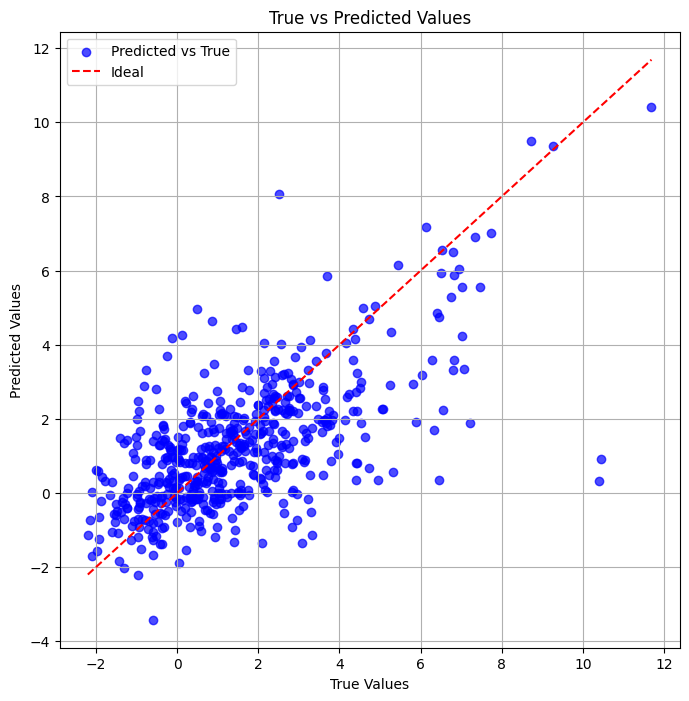

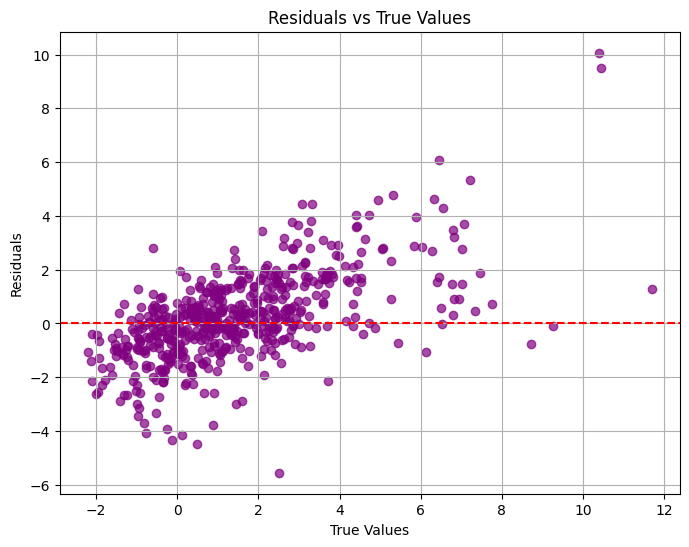

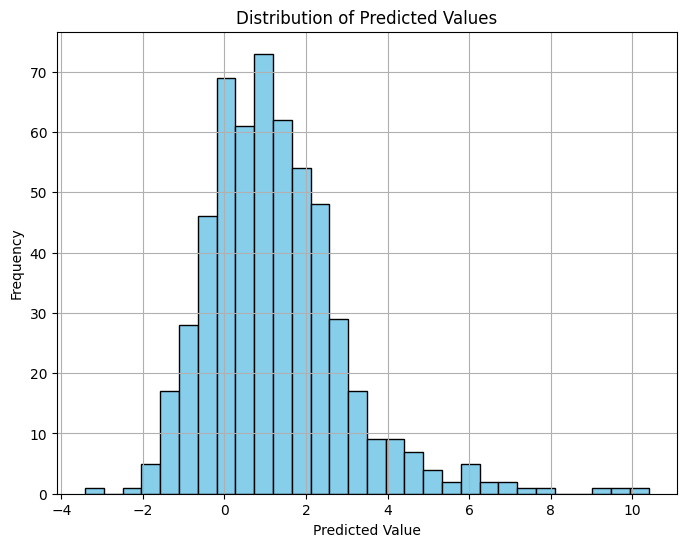

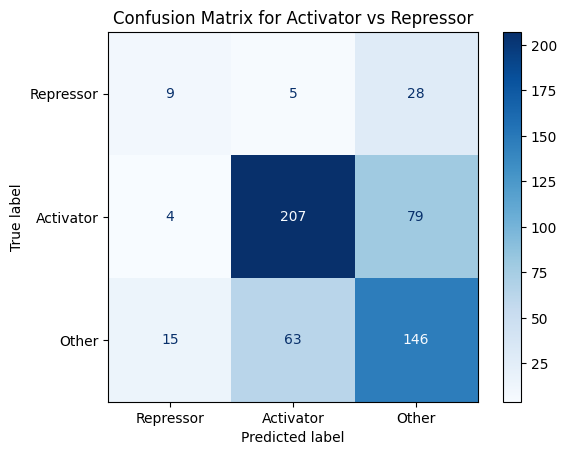

Classification Report:
              precision    recall  f1-score   support

   Repressor       0.32      0.21      0.26        42
   Activator       0.75      0.71      0.73       290
       Other       0.58      0.65      0.61       224

    accuracy                           0.65       556
   macro avg       0.55      0.53      0.53       556
weighted avg       0.65      0.65      0.65       556



In [33]:
train_losses, test_losses, test_loader, model_folder, all_true_values, all_predicted_values = cross_validate_stratified(
    graphs, 'GAT_trial_stratisfied', model_type='GAT', k_folds=5, num_epochs=200, hidden_dim=64, out_dim=32
)
# Flatten the true and predicted values (since they are collected over multiple epochs/folds)
all_true_values = [item for sublist in all_true_values for item in sublist]
all_predicted_values = [item for sublist in all_predicted_values for item in sublist]

# Now you can call the plotting functions with these values:
plot_true_vs_predicted(all_true_values, all_predicted_values)
plot_residuals(all_true_values, all_predicted_values)
plot_predicted_histogram(all_predicted_values)
plot_confusion_matrix(all_true_values, all_predicted_values)


Running cross-validation for Linear
Fold 1/5
Epoch 1/100, Train Loss: 233.58947229385376, Test Loss: 26.01220737184797
Epoch 2/100, Train Loss: 16.200862884521484, Test Loss: 6.71662289755685
Epoch 3/100, Train Loss: 6.764606935637338, Test Loss: 5.269475187574114
Epoch 4/100, Train Loss: 5.517697104385921, Test Loss: 5.117398244994027
Epoch 5/100, Train Loss: 4.9599942820412775, Test Loss: 4.56383660861424
Epoch 6/100, Train Loss: 5.290602488177163, Test Loss: 8.578693321772985
Epoch 7/100, Train Loss: 5.4137067667075565, Test Loss: 4.959337404796055
Epoch 8/100, Train Loss: 5.297499307564327, Test Loss: 4.423674123627799
Epoch 9/100, Train Loss: 4.825094056980951, Test Loss: 4.819442408425467
Epoch 10/100, Train Loss: 6.292722991534641, Test Loss: 7.137614352362497
Epoch 11/100, Train Loss: 7.44171468274934, Test Loss: 5.5184690952301025
Epoch 12/100, Train Loss: 4.352600012506757, Test Loss: 5.162224156515939
Epoch 13/100, Train Loss: 5.633379855326244, Test Loss: 7.159943750926426


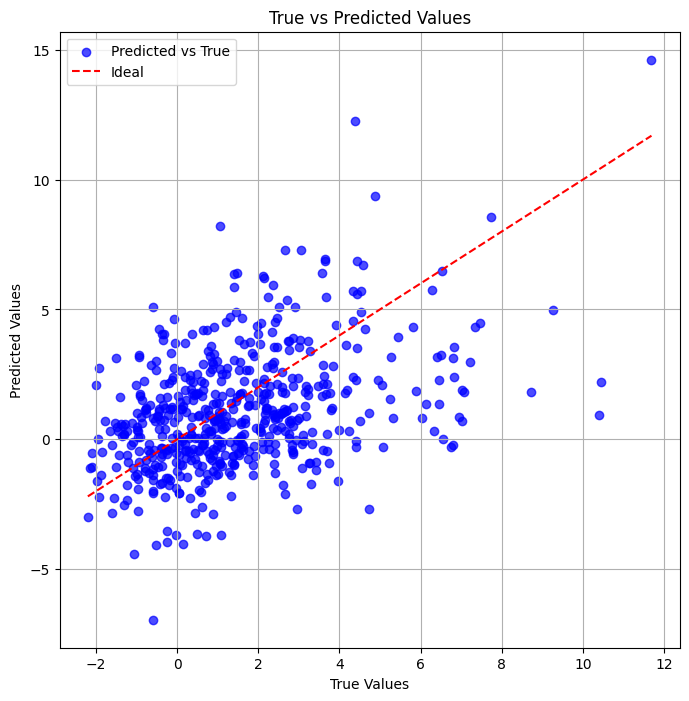

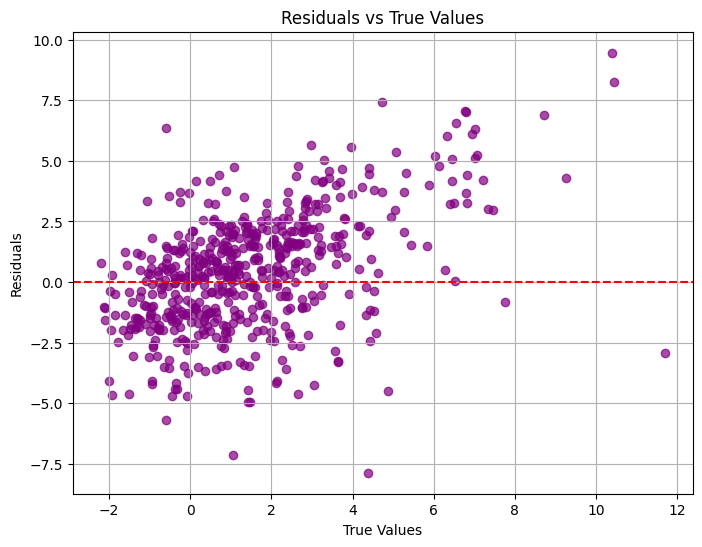

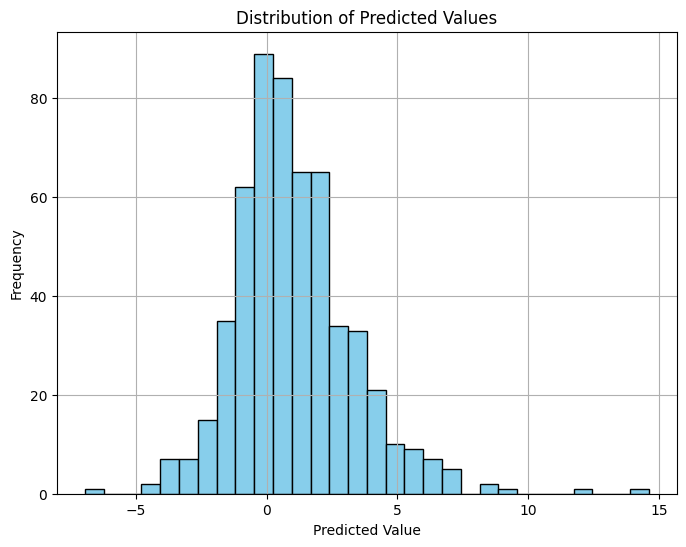

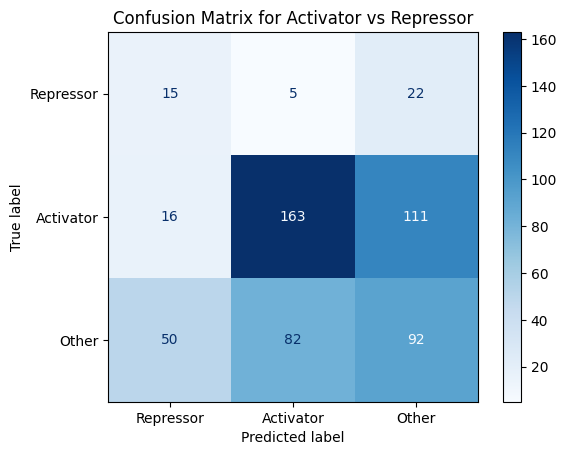

Classification Report:
              precision    recall  f1-score   support

   Repressor       0.19      0.36      0.24        42
   Activator       0.65      0.56      0.60       290
       Other       0.41      0.41      0.41       224

    accuracy                           0.49       556
   macro avg       0.42      0.44      0.42       556
weighted avg       0.52      0.49      0.50       556

Running cross-validation for MLP
Fold 1/5
Epoch 1/100, Train Loss: 18.56373871224267, Test Loss: 6.469998598098755
Epoch 2/100, Train Loss: 7.262032215084348, Test Loss: 7.00291337285723
Epoch 3/100, Train Loss: 5.910909448351179, Test Loss: 6.322625092097691
Epoch 4/100, Train Loss: 5.521552613803318, Test Loss: 5.834783298628671
Epoch 5/100, Train Loss: 5.178777754306793, Test Loss: 6.925349950790405
Epoch 6/100, Train Loss: 5.493514972073691, Test Loss: 5.82622458253588
Epoch 7/100, Train Loss: 5.070120543241501, Test Loss: 5.068501029695783
Epoch 8/100, Train Loss: 4.384134254285267, T

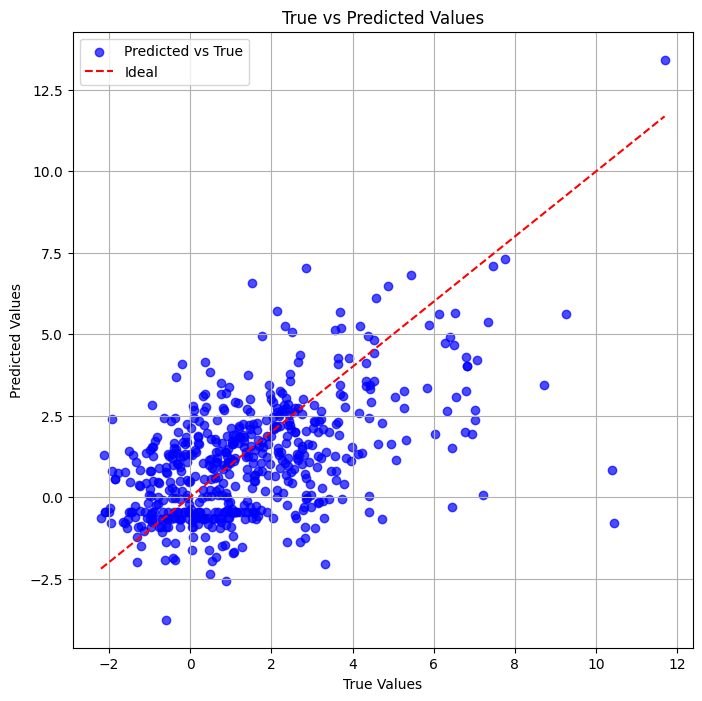

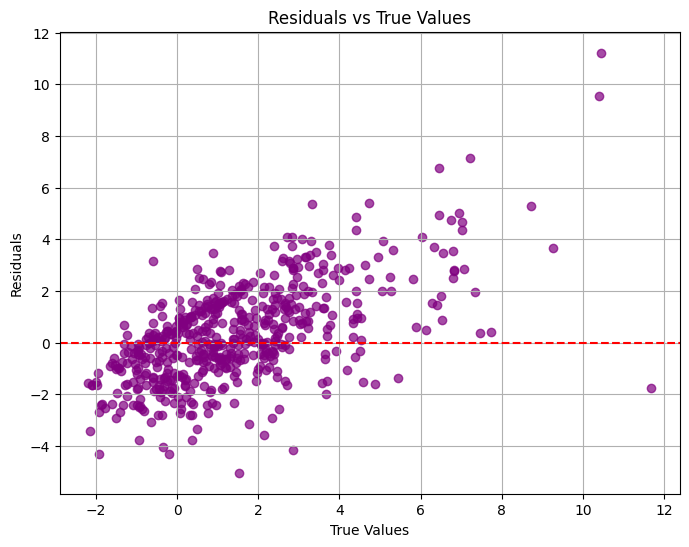

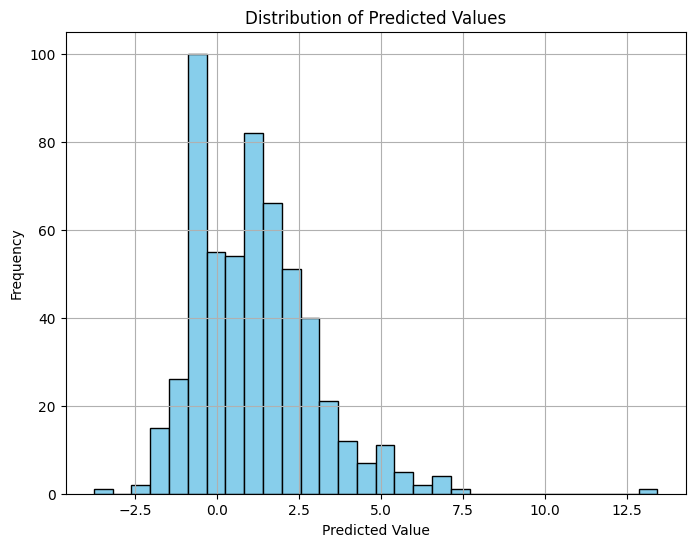

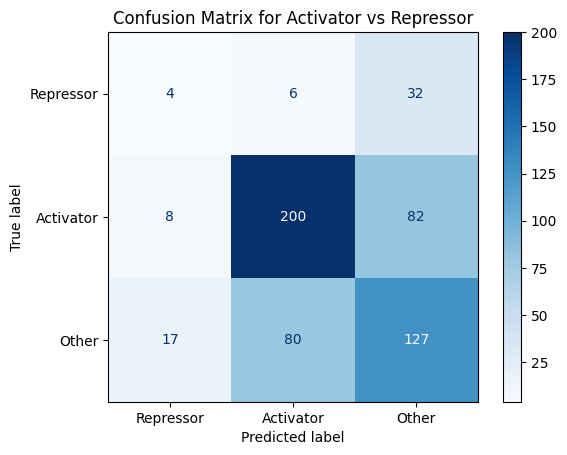

Classification Report:
              precision    recall  f1-score   support

   Repressor       0.14      0.10      0.11        42
   Activator       0.70      0.69      0.69       290
       Other       0.53      0.57      0.55       224

    accuracy                           0.60       556
   macro avg       0.45      0.45      0.45       556
weighted avg       0.59      0.60      0.59       556

Running cross-validation for Transformer
Fold 1/5
Adjusted number of heads: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, Train Loss: 7.163603080170495, Test Loss: 6.983151776450021
Epoch 2/100, Train Loss: 6.659986951521465, Test Loss: 7.061763082231794
Epoch 3/100, Train Loss: 6.772744204316821, Test Loss: 6.997044631413051
Epoch 4/100, Train Loss: 6.610998264380863, Test Loss: 6.993725981031146
Epoch 5/100, Train Loss: 6.60319692322186, Test Loss: 7.643019471849714
Epoch 6/100, Train Loss: 6.593791399683271, Test Loss: 7.054338216781616
Epoch 7/100, Train Loss: 6.5485895446368625, Test Loss: 7.095409870147705
Epoch 8/100, Train Loss: 6.647405645677021, Test Loss: 7.154487235205514
Epoch 9/100, Train Loss: 6.655593803950718, Test Loss: 7.0201871906008035
Epoch 10/100, Train Loss: 6.643952812467303, Test Loss: 7.084158420562744
Epoch 11/100, Train Loss: 6.622450794492449, Test Loss: 7.010713287762234
Epoch 12/100, Train Loss: 6.536660752126148, Test Loss: 7.0399327618735175
Epoch 13/100, Train Loss: 6.4943801164627075, Test Loss: 7.0344559124537875
Epoch 14/100, Train Loss: 6.593787176268441

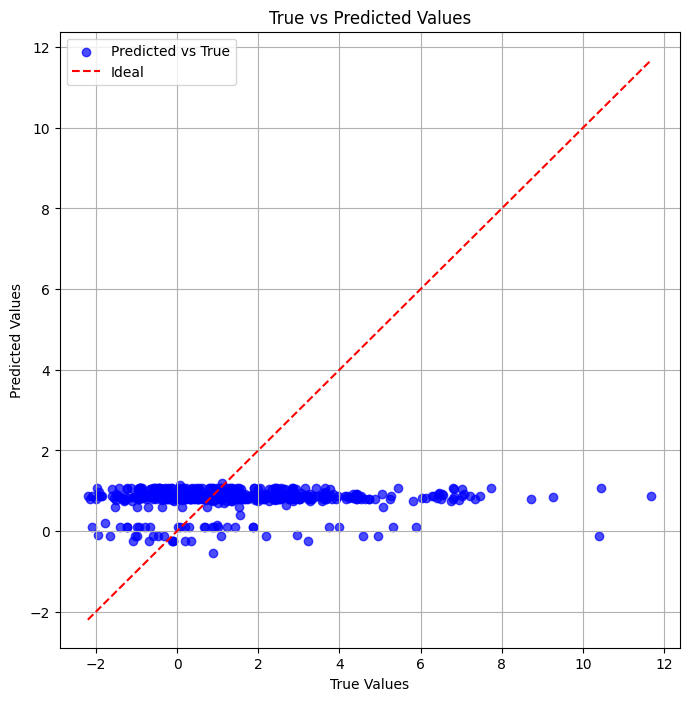

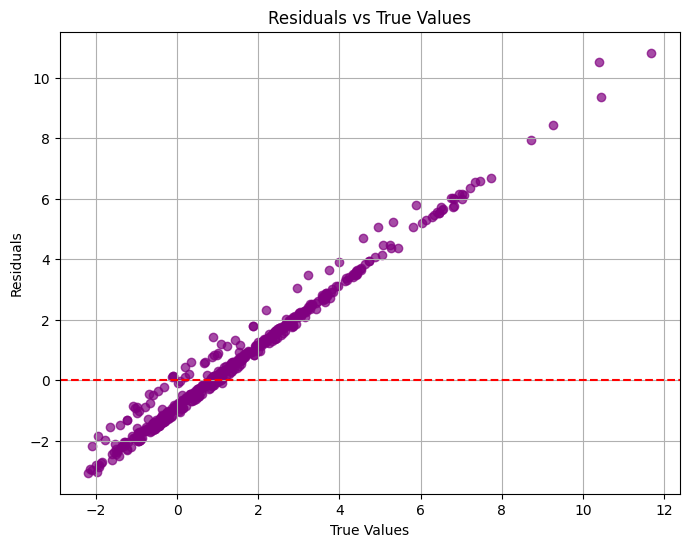

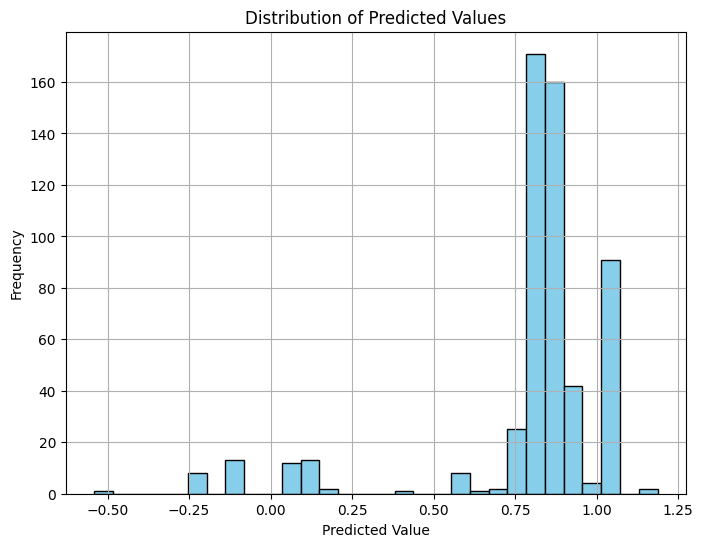

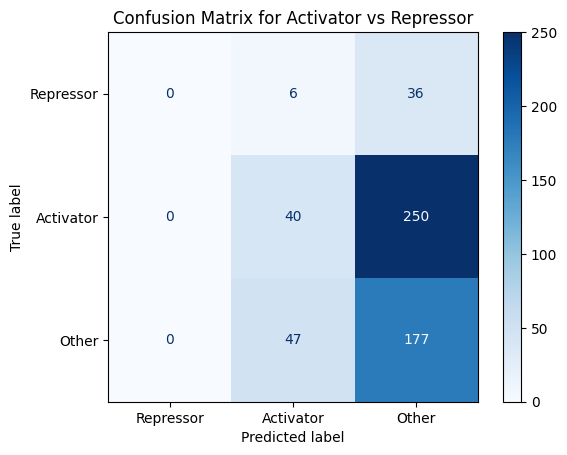

Classification Report:
              precision    recall  f1-score   support

   Repressor       0.00      0.00      0.00        42
   Activator       0.43      0.14      0.21       290
       Other       0.38      0.79      0.52       224

    accuracy                           0.39       556
   macro avg       0.27      0.31      0.24       556
weighted avg       0.38      0.39      0.32       556

Running cross-validation for GNN
Fold 1/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100, Train Loss: 7.4461954065731595, Test Loss: 6.092350210462298
Epoch 2/100, Train Loss: 6.327457534415381, Test Loss: 5.836368697030204
Epoch 3/100, Train Loss: 5.992212410484042, Test Loss: 4.8670390503747125
Epoch 4/100, Train Loss: 5.402323484420776, Test Loss: 5.658726607050214
Epoch 5/100, Train Loss: 5.3548217969281335, Test Loss: 4.5665861538478305
Epoch 6/100, Train Loss: 5.060184282915933, Test Loss: 4.137460895947048
Epoch 7/100, Train Loss: 5.141658791473934, Test Loss: 4.819712911333356
Epoch 8/100, Train Loss: 4.753904368196215, Test Loss: 4.38275500706264
Epoch 9/100, Train Loss: 4.698058311428342, Test Loss: 5.759119646889823
Epoch 10/100, Train Loss: 4.898471653461456, Test Loss: 4.508405004228864
Epoch 11/100, Train Loss: 4.622669718095234, Test Loss: 3.8946769067219327
Epoch 12/100, Train Loss: 4.625534479107175, Test Loss: 4.038456303732736
Epoch 13/100, Train Loss: 4.14293755378042, Test Loss: 5.014700821467808
Epoch 14/100, Train Loss: 4.3604936003685, T

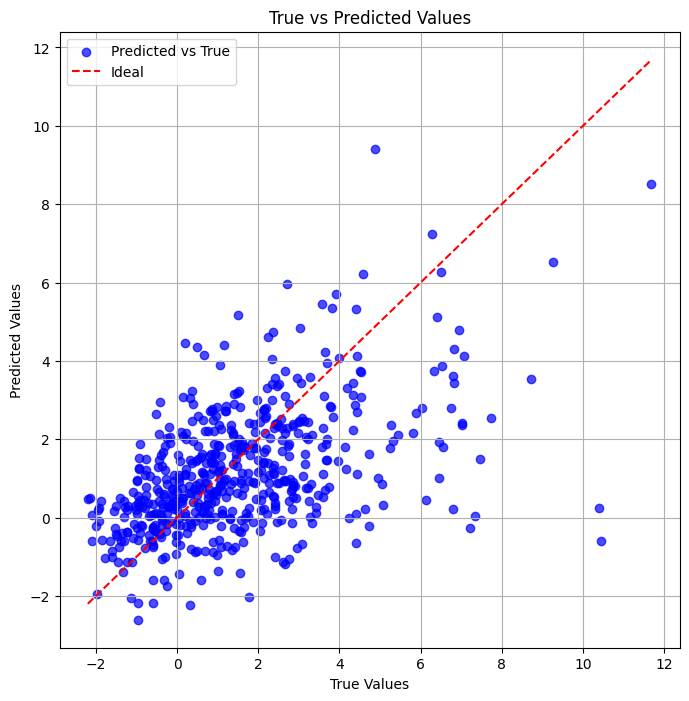

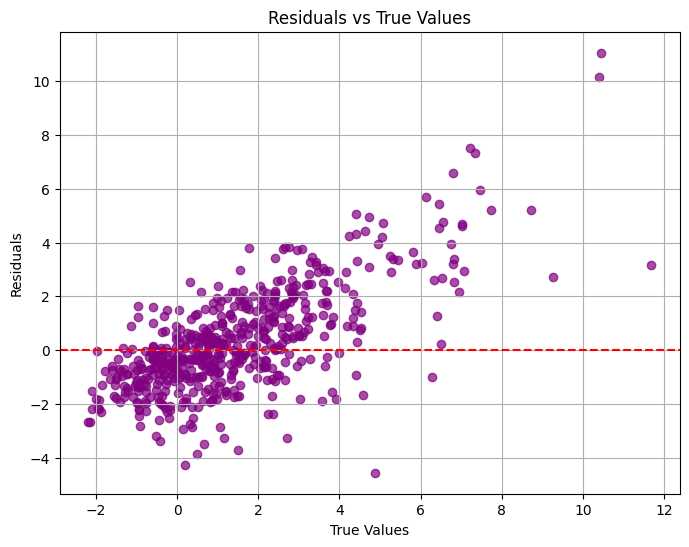

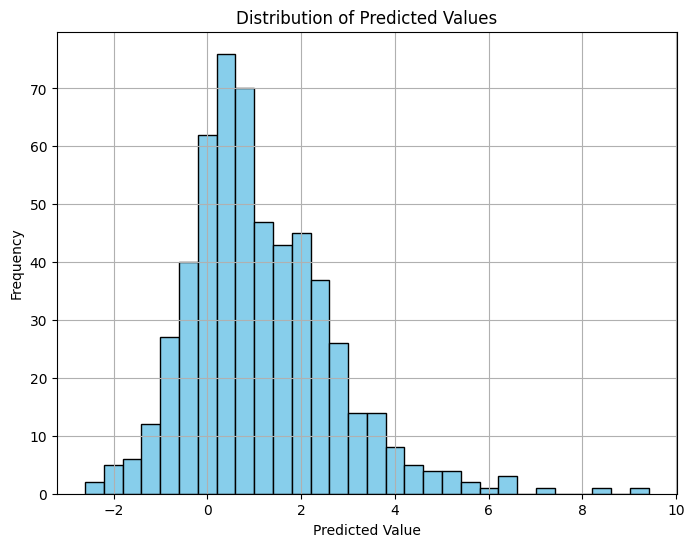

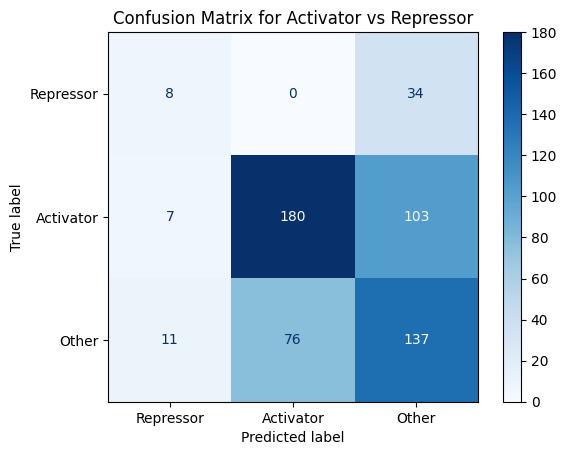

Classification Report:
              precision    recall  f1-score   support

   Repressor       0.31      0.19      0.24        42
   Activator       0.70      0.62      0.66       290
       Other       0.50      0.61      0.55       224

    accuracy                           0.58       556
   macro avg       0.50      0.47      0.48       556
weighted avg       0.59      0.58      0.58       556

Running cross-validation for GAT
Fold 1/5
Epoch 1/100, Train Loss: 7.5004410062517435, Test Loss: 5.624684197562082
Epoch 2/100, Train Loss: 6.875665766852243, Test Loss: 5.340126412255423
Epoch 3/100, Train Loss: 6.432736098766327, Test Loss: 5.169545616422381
Epoch 4/100, Train Loss: 5.753837274653571, Test Loss: 4.50400173664093
Epoch 5/100, Train Loss: 5.090275368520191, Test Loss: 4.773706776755197
Epoch 6/100, Train Loss: 4.954919363771166, Test Loss: 7.82342529296875
Epoch 7/100, Train Loss: 4.8403220900467465, Test Loss: 3.562854085649763
Epoch 8/100, Train Loss: 4.748538149254663,

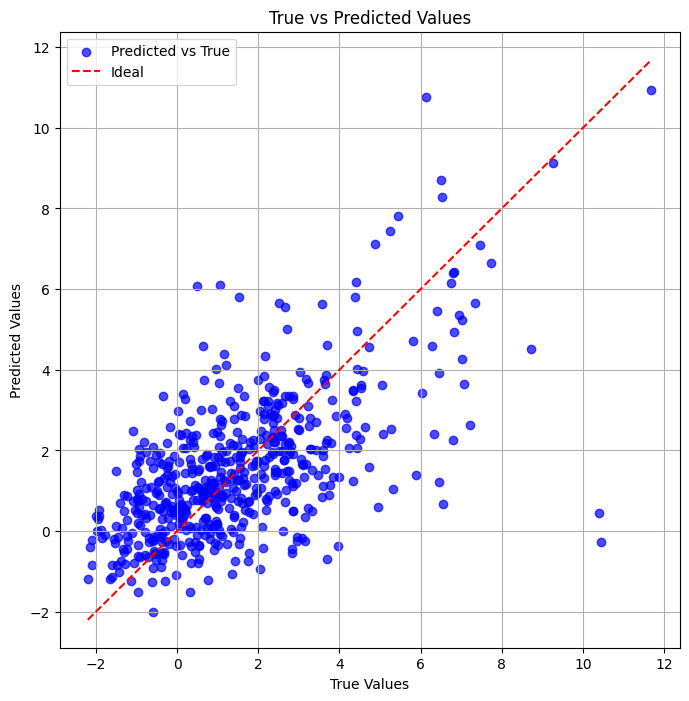

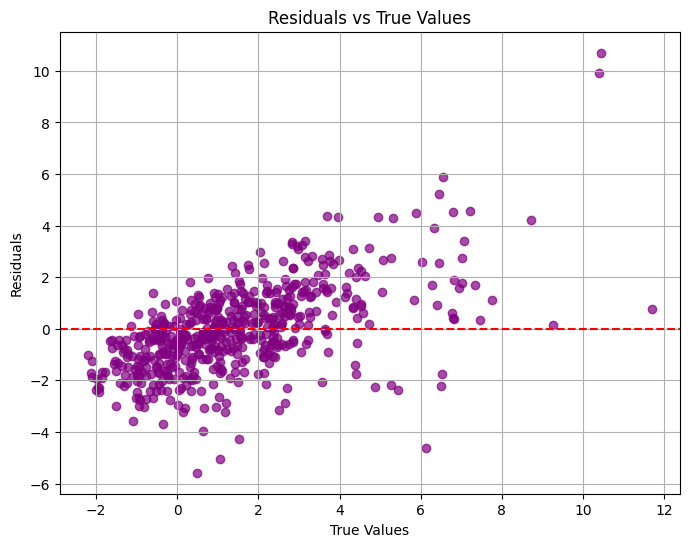

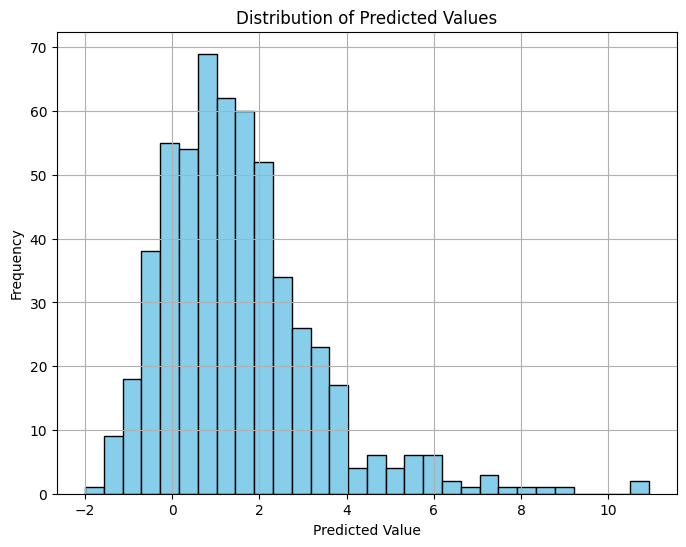

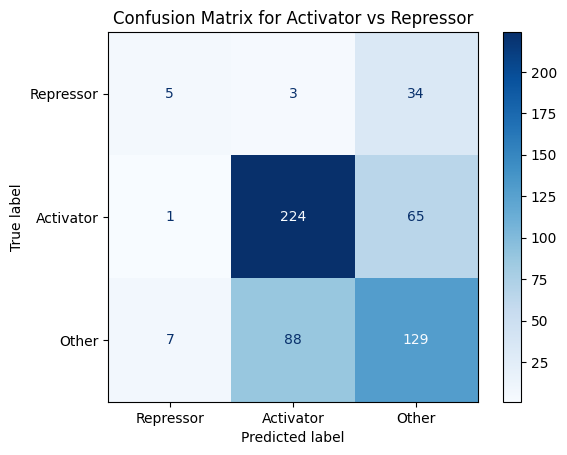

Classification Report:
              precision    recall  f1-score   support

   Repressor       0.38      0.12      0.18        42
   Activator       0.71      0.77      0.74       290
       Other       0.57      0.58      0.57       224

    accuracy                           0.64       556
   macro avg       0.55      0.49      0.50       556
weighted avg       0.63      0.64      0.63       556



In [43]:
# Example usage of cross-validation without straisfication
# train_losses, test_losses, test_loader, model_folder, all_true_values, all_predicted_values = cross_validate(
#     graphs, 'GAT_trial', model_type='GAT', k_folds=5, num_epochs=200, hidden_dim=64, out_dim=32
# )

models_to_try = ['Linear', 'MLP', 'Transformer', 'GNN', 'GAT']
for model_type in models_to_try:
    print(f'Running cross-validation for {model_type}')
    weights_name = f'{model_type}_trial'
    train_losses, test_losses, test_loader, model_folder, all_true_values, all_predicted_values = cross_validate_stratified(
        graphs, weights_name, model_type=model_type, k_folds=5, num_epochs=100, hidden_dim=64, out_dim=32
    )

  # Flatten the true and predicted values (since they are collected over multiple epochs/folds)
    all_true_values = [item for sublist in all_true_values for item in sublist]
    all_predicted_values = [item for sublist in all_predicted_values for item in sublist]
    print(f"----------------MODEL: {model_type}-----------------")
    # Now you can call the plotting functions with these values:
    plot_true_vs_predicted(all_true_values, all_predicted_values)
    plot_residuals(all_true_values, all_predicted_values)
    plot_predicted_histogram(all_predicted_values)
    plot_confusion_matrix(all_true_values, all_predicted_values)

